In [19]:
import os
import IPython
from ipywidgets import interact
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import matplotlib.image as mpimg
from tabulate import tabulate

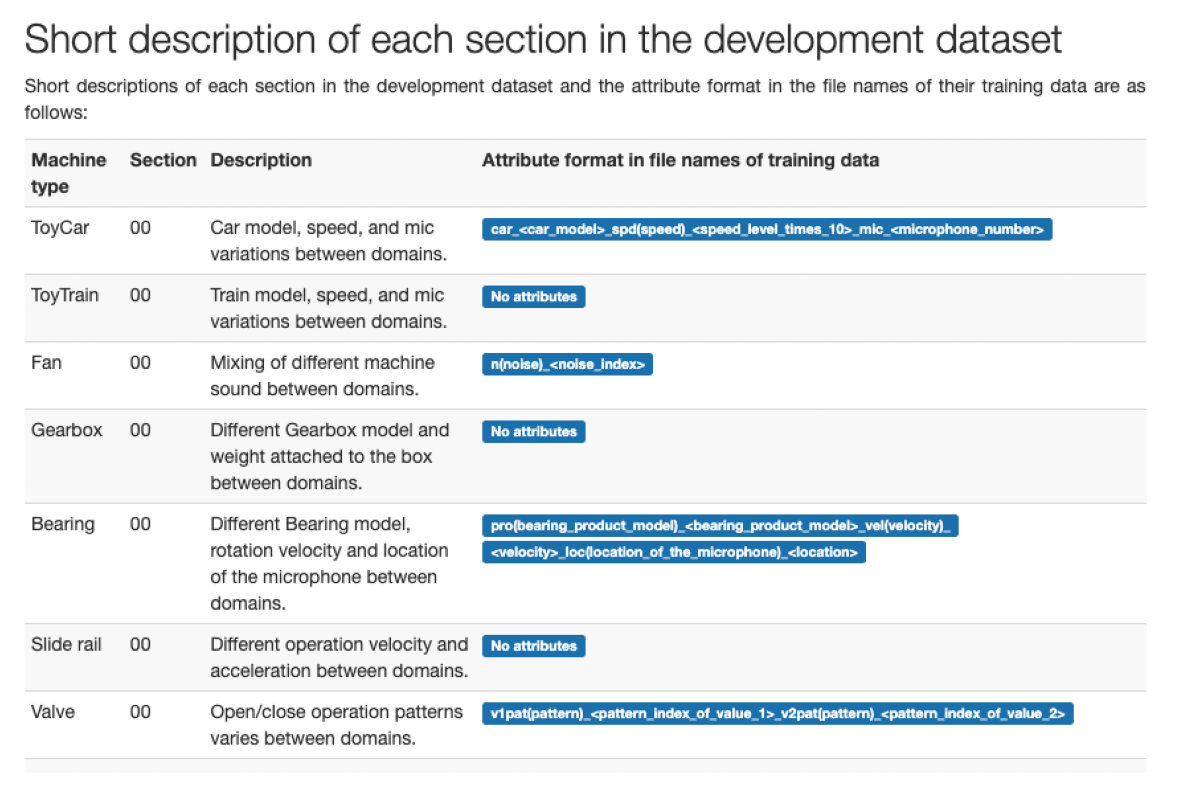

In [20]:
# Read Images
plt.figure(figsize=(15,15))
img = mpimg.imread('attributes.png')
plt.axis("off")
plt.imshow(img)

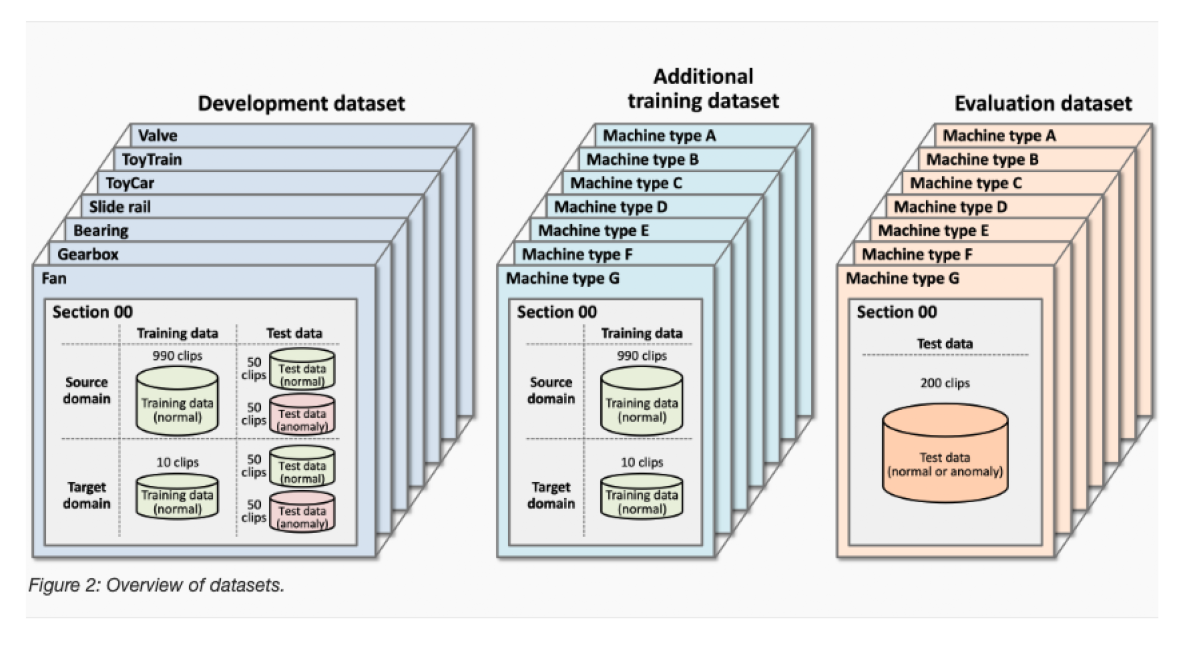

In [21]:
# Read Images
plt.figure(figsize=(15,15))
img = mpimg.imread('data_img.png')
plt.axis("off")
plt.imshow(img)

In [22]:
#get all the path of the file
current_path = os.getcwd()
dev_path = os.path.join(os.path.dirname(current_path) , '10902294')

#choices
machine_choice = [i for i in os.listdir(dev_path) if (".DS_Store" not in i) and  ".zip" not in i]
data_choice = ["train", "test"]
domain_choice = ["source","target"]
condition_choice = ["normal", "anomaly"]

In [27]:
#get the files name based on machine, data, domain and type choices
def sub_df_from_name (df:pd.DataFrame,name:str):
    indices = []
    for file in df["file_name"].tolist():
        if name in file:
            idx = df["file_name"].tolist().index(file)
            indices.append(idx)

    return df.iloc[indices]

def concat_key(*args):
    key = ""
    for arg in args:
        key = key + arg + "_"

    return key[:-1]

def create_dict_unique_count(dev_path, machine_choice):

    # attribute file 
    name_attributt = "attributes_00.csv"

    # create dict unique count
    dict_unique_count = {}
    
    #machine type
    for machine in machine_choice:
        attributt_path = os.path.join(dev_path,machine,name_attributt)
        df = pd.read_csv(attributt_path)

        #data type
        for type in ["train","test"]:
            sub_df_type = sub_df_from_name(df,type)

            #domain type
            for domain in ["source","target"]:
                sub_df_domain = sub_df_from_name(sub_df_type,domain)
                
                #condition type
                for condition in ["normal","anomaly"]:
                    
                    sub_df_condition = sub_df_from_name(sub_df_domain,condition)
                    if len (sub_df_condition) > 0:

                        #create dict of dict unique count based on keys
                        key = concat_key(machine,type, domain, condition)
                        dict_unique_count[key] = {}

                        arr_attribute = np.array(sub_df_condition.loc[:,sub_df_condition.columns[1:]]) 
                        arr_attribute = np.array (["_".join(str(j) for j in i) for i in arr_attribute ])

                        unique_attributes, counts = np.unique(arr_attribute, return_counts=True)
                        
                        if len(unique_attributes) == 1:
                            unique_attributes = ["noAttribute"]

                        for i in range(len(unique_attributes)):
                            att = unique_attributes[i]
                            count = counts[i] 
                            dict_unique_count[key][att] = count
        
    return dict_unique_count

dict_unique_count = create_dict_unique_count(dev_path,machine_choice)

#visualize as tabular
def visualize_tabular (dict_unique_count):
    tab_dict = {}

    tab_dict["Machine"] = []
    tab_dict["Data"] =  []
    tab_dict["Domain"] =  []
    tab_dict["Condition"] =  []
    tab_dict["Attributes"] = []
    tab_dict["Counts"] = []

    for key_out in dict_unique_count.keys():
        split_key = key_out.split("_")
        machine, data, domain, condition = split_key[0],split_key[1],split_key[2],split_key[3]
        list_key_in = dict_unique_count[key_out].keys()
        
        for key_in in list_key_in:
            tab_dict["Machine"].append(machine)
            tab_dict["Data"].append(data)
            tab_dict["Domain"].append(domain)
            tab_dict["Condition"].append(condition)

            tab_dict["Attributes"].append(key_in)
            tab_dict["Counts"].append(dict_unique_count[key_out][key_in])
            
    return tab_dict

tabular_dict = visualize_tabular(dict_unique_count)
tabular = tabulate(tabular_data=tabular_dict,headers="keys")
print(tabular)
 
#save tabel as csv file
df_table = pd.DataFrame(tabular_dict)
df_name = "data_info.csv"
df_table.to_csv(df_name,index=False)

Machine    Data    Domain    Condition    Attributes                  Counts
---------  ------  --------  -----------  ------------------------  --------
bearing    train   source    normal       pro_A_vel_12_loc_A              62
bearing    train   source    normal       pro_A_vel_12_loc_B              62
bearing    train   source    normal       pro_A_vel_12_loc_C              62
bearing    train   source    normal       pro_A_vel_12_loc_D              62
bearing    train   source    normal       pro_A_vel_4_loc_A               61
bearing    train   source    normal       pro_A_vel_4_loc_B               62
bearing    train   source    normal       pro_A_vel_4_loc_C               62
bearing    train   source    normal       pro_A_vel_4_loc_D               62
bearing    train   source    normal       pro_B_vel_16_loc_A              62
bearing    train   source    normal       pro_B_vel_16_loc_B              62
bearing    train   source    normal       pro_B_vel_16_loc_C              62

In [24]:
@interact(machine = machine_choice, data = data_choice, condition = condition_choice, domain = domain_choice)
def load_clip (machine,data,domain, condition):

    #load all clips
    clip_path = os.path.join(dev_path,machine,data)
    clip_name = [i for i in os.listdir(clip_path) if ".DS_Store" not in i]
    
    #visualize
    def visualize (clip, clip_bearing, key_word_data = None,key_word_att = None):
        #key word index
        if key_word_data is not None and key_word_att is not None:
            key_word = "{}_{}_{}".format(key_word_data,clip,key_word_att)
            selection = [i for i in clip_bearing if key_word in i]
            if len(selection) == 0:
                return "No clips are founded"
            else:
                selection = selection[0]
            path_selection = os.path.join(clip_path,selection)

        else:
            key_word = "{}_{}".format(key_word_data,clip)
            selection = [i for i in clip_bearing if key_word in i]
            if len(selection) == 0:
                return "No clips are founded"
            else:
                selection = selection[0]
            path_selection = os.path.join(clip_path, selection)
            
        #display the audio clip
        display(IPython.display.Audio(path_selection))

        #visualize with numpy array
        sampling_freq, array = wavfile.read(path_selection)
        print("sampling_freq:", sampling_freq)

        duration = len(array) / sampling_freq
        print("duration:", duration)

        duration = np.linspace(0,duration, len(array))
        plt.figure(figsize=(20,10))
        plt.plot(duration,array)
        plt.title(selection)
        plt.xlabel("Duration (s)")
        plt.ylabel("Magnitude")
        
    #attributtes bearing
    if machine == "bearing":
        pro_choice = ["A","B"]
        vel_choice = [4,8,12,16]
        if (data == "train" and condition == "normal") or (data == "test" and condition == "normal") or (data == "test" and condition == "anomaly") :
            if domain == "source":
                loc_choice = ['A', 'B', 'C', 'D']
            elif domain == "target":
                loc_choice = ['E', 'F', 'G' ,'H']
        else:
            return "No clips are founded"
 
        @interact(pro = pro_choice, vel = vel_choice,loc = loc_choice)
        def bearing_clip(pro, vel, loc):
            
            #key word data, domain, condtion and attributtes
            key_word_data = "{}_{}_{}".format(domain,data,condition)
            key_word_att = "pro_{}_vel_{}_loc_{}".format(pro,vel,loc)
            clip_bearing = [i for i in clip_name if (key_word_data in i) and (key_word_att in i)]
            clip_indices = [i.split("_")[5] for i in clip_bearing]

            @interact(clip = clip_indices)
            def clip_select(clip):
                return visualize(clip,clip_bearing,key_word_data, key_word_att)
                
    #attributtes fan
    elif machine == "fan":
        if (data == "train" and condition == "normal") or (data == "test" and condition == "normal") or (data == "test" and condition == "anomaly") :
            if domain == "source":
                n_choice = ['A', 'B']
            elif domain == "target":
                n_choice = ['X', 'Y']
        else:
            return "No clips are founded"
        
        @interact(n = n_choice)
        def fan_clip(n):
            
            #key word data, domain, condtion and attributtes
            key_word_data = "{}_{}_{}".format(domain,data,condition)
            key_word_att = "n_{}".format(n)
            clip_bearing = [i for i in clip_name if (key_word_data in i) and (key_word_att in i)]
            clip_indices = [i.split("_")[5] for i in clip_bearing]

            @interact(clip = clip_indices)
            def clip_select(clip):
                return visualize(clip,clip_bearing,key_word_data, key_word_att)
            
    #attributtes gearbox, slider, ToyTrain
    elif machine in ["gearbox","slider", "ToyTrain"]:
        if (data == "train" and condition == "normal") or (data == "test" and condition == "normal") or (data == "test" and condition == "anomaly") :
            
            #key word data, domain, condtion
            key_word_data = "{}_{}_{}".format(domain,data,condition)
            clip_bearing = [i for i in clip_name if key_word_data in i]
            clip_indices = [i.split("_")[5] for i in clip_bearing]

            @interact(clip = clip_indices)
            def clip_select(clip):
                return visualize(clip,clip_bearing,key_word_data=key_word_data)
        else:
            return "No clips are founded"
    
    #attributtes ToyCar
    if machine == "ToyCar":
        if (data == "train" and condition == "normal") or (data == "test" and condition == "normal") or (data == "test" and condition == "anomaly") :
            if domain == "source":
                v1pat_choice = ['B1', 'B2', 'C1', 'C2', 'D1', 'D2']
                v2pat_choice = ['31V', '34V', '40V']
                mic_choice = ['1.wav']
            elif domain == "target":
                v1pat_choice = ['A1', 'A2', 'E1', 'E2']
                v2pat_choice = ['28V', '37V']
                mic_choice = ['2.wav']
        else:
            return "No clips are founded"
 
        @interact(car = v1pat_choice, spd = v2pat_choice,mic = mic_choice)
        def bearing_clip(car, spd, mic):
            
            #key word data, domain, condtion and attributtes
            key_word_data = "{}_{}_{}".format(domain,data,condition)
            key_word_att = "car_{}_spd_{}_mic_{}".format(car, spd, mic)
            clip_bearing = [i for i in clip_name if (key_word_data in i) and (key_word_att in i)]
            clip_indices = [i.split("_")[5] for i in clip_bearing]

            @interact(clip = clip_indices)
            def clip_select(clip):
                return visualize(clip,clip_bearing,key_word_data, key_word_att)
            
    #attributtes vavle
    if machine == "valve":
        if (data == "train" and condition == "normal") or (data == "test" and condition == "normal") or (data == "test" and condition == "anomaly") :
            if domain == "source":
                v1pat_choice = ['A', 'B', 'none']
                v2pat_choice = ['B', 'none']
            elif domain == "target":
                v1pat_choice = ['A', 'B']
                v2pat_choice = ['B']
        else:
            return "No clips are founded"
 
        @interact(v1pat = v1pat_choice, v2pat = v2pat_choice)
        def bearing_clip(v1pat, v2pat):
            
            #key word data, domain, condtion and attributtes
            key_word_data = "{}_{}_{}".format(domain,data,condition)
            key_word_att = "v1pat_{}_v2pat_{}".format(v1pat, v2pat)
            clip_bearing = [i for i in clip_name if (key_word_data in i) and (key_word_att in i)]
            clip_indices = [i.split("_")[5] for i in clip_bearing]

            @interact(clip = clip_indices)
            def clip_select(clip):
                return visualize(clip,clip_bearing,key_word_data, key_word_att)

interactive(children=(Dropdown(description='machine', options=('bearing', 'fan', 'gearbox', 'slider', 'ToyCar'…

# References

[DCASE2024](https://dcase.community/challenge2024/task-first-shot-unsupervised-anomalous-sound-detection-for-machine-condition-monitoring)